# Importing Libraries

In [23]:
import pandas as pd
import re, nltk, spacy, gensim
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Preprocessing Data

In [4]:
df = pd.read_csv('comments.csv', on_bad_lines='skip', encoding='unicode_escape')

In [5]:
data = df['Comment']

In [6]:
data = [re.sub(r'\s+', ' ', sent) for sent in data] #Removing extra whitespace
data = [re.sub(r"\'", "", sent) for sent in data] #Removed punctuation

In [7]:
# Tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
data_words = list(sent_to_words(data))

In [8]:
# Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [9]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words) 

In [10]:
#Vectorization
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10, 		# minimum reqd occurences of a word 
                             stop_words='english',	# remove stop words
                             lowercase=True,            # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')
X = vectorizer.fit_transform(data_lemmatized)

In [11]:
y = df['Target']

# Modelling

## Un-Supervised Machine Learning

### K Means

building 2 feature SVD
<class 'numpy.ndarray'> (1068, 2)


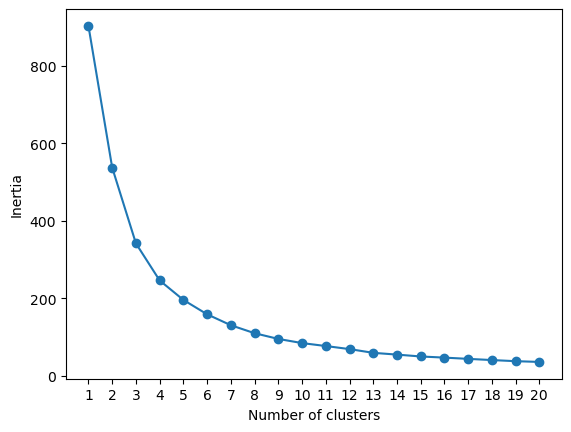

In [12]:
# Dimension Reduction
svd = TruncatedSVD(n_components=2, n_iter=300, random_state=42)
print("building",2,"feature SVD")
reduced_X = svd.fit_transform(X)
print(type(reduced_X), reduced_X.shape)#, reduced_bow.head())

MAX_CLUSTERS = 20
inertias = []
for k in range(1, MAX_CLUSTERS + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_X)
    inertias.append(kmeans.inertia_)

# Plot the elbow plot
x = range(1, MAX_CLUSTERS + 1)
import matplotlib.pyplot as plt
plt.plot(x, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()

## Supervised Machine Learning

In [26]:
#Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Naive Bayes

In [27]:
# Create a Naive Bayes object
model = GaussianNB()

# Define tuning parameters
var_smoothing = np.logspace(0,-9, num=10)

# define grid search
grid = dict(var_smoothing=var_smoothing)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train.toarray(), y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.800939 using {'var_smoothing': 1.0}
0.800939 (0.015358) with: {'var_smoothing': 1.0}
0.778659 (0.035137) with: {'var_smoothing': 0.1}
0.674432 (0.054319) with: {'var_smoothing': 0.01}
0.482348 (0.059968) with: {'var_smoothing': 0.001}
0.428482 (0.063194) with: {'var_smoothing': 0.0001}
0.385586 (0.057209) with: {'var_smoothing': 1e-05}
0.365321 (0.049922) with: {'var_smoothing': 1e-06}
0.353625 (0.047614) with: {'var_smoothing': 1e-07}
0.350114 (0.047905) with: {'var_smoothing': 1e-08}
0.346986 (0.047000) with: {'var_smoothing': 1e-09}


The accuracy of the Naive Bayes model is: 0.8084112149532711
AUC: 0.669


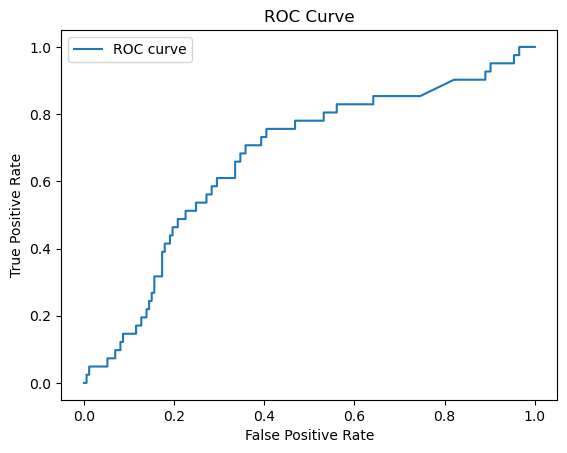

In [28]:
# Using the best model from CV
tuned_model = grid_result.best_estimator_
predictions = tuned_model.predict_proba(X_test.toarray())[:, 1]

# Evaluate the model on the testing data
score = tuned_model.score(X_test.toarray(), y_test)
print('The accuracy of the Naive Bayes model is:', score)

# Calculate the ROC curve for Naive Bayes
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)

# Plot the ROC curve for Naive Bayes
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Logistic Regression

In [29]:
# Create a Logistic Regression object
model = LogisticRegression()

# Define tuning parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.817711 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.735381 (0.032521) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.757962 (0.031356) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.758349 (0.031691) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.757962 (0.031356) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'lbfgs'}
0.762631 (0.033933) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.782540 (0.029158) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.782540 (0.029158) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.782540 (0.029158) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: 

The accuracy of the Logistic Regression model is: 0.7757009345794392
AUC: 0.661


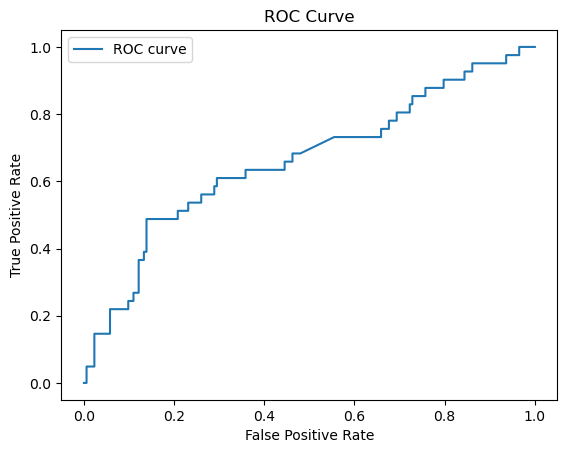

In [30]:
# Using the best model from CV
tuned_model = grid_result.best_estimator_
predictions = tuned_model.predict_proba(X_test)[:, 1]

# Evaluate the model on the testing data
score = tuned_model.score(X_test, y_test)
print('The accuracy of the Logistic Regression model is:', score)

# Calculate the ROC curve for Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)

# Plot the ROC curve for Logistic Regression
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Bagged Decision Trees

In [31]:
# define model and tuning parameters
model = BaggingClassifier()
n_estimators = [10, 100, 1000]

# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.776329 using {'n_estimators': 100}
0.773552 (0.037788) with: {'n_estimators': 10}
0.776329 (0.035751) with: {'n_estimators': 100}
0.775171 (0.032015) with: {'n_estimators': 1000}


The accuracy of the Bagged Decision Tree is: 0.7757009345794392
AUC: 0.744


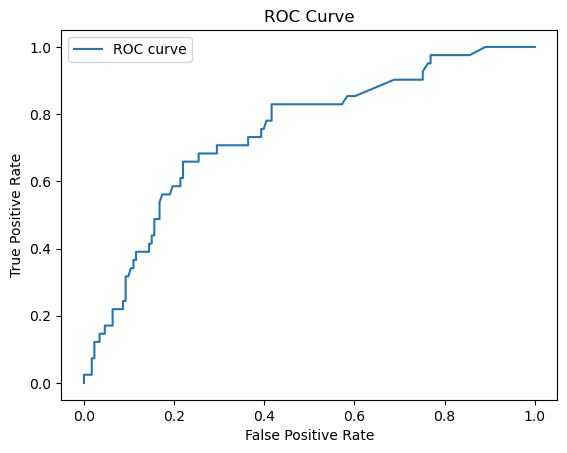

In [32]:
# Using the best model from CV
tuned_model = grid_result.best_estimator_
predictions = tuned_model.predict_proba(X_test)[:, 1]

# Evaluate the model on the testing data
score = tuned_model.score(X_test, y_test)
print('The accuracy of the Bagged Decision Tree is:', score)

# Calculate the ROC curve for Bagged Decision Tree
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)

# Plot the ROC curve for Bagged Decision Tree
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Random Forest

In [33]:
# define model and tuning parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.810716 using {'max_features': 'log2', 'n_estimators': 1000}
0.794305 (0.034381) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.798573 (0.028408) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.800520 (0.028915) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.800128 (0.027747) with: {'max_features': 'log2', 'n_estimators': 10}
0.809558 (0.026746) with: {'max_features': 'log2', 'n_estimators': 100}
0.810716 (0.027535) with: {'max_features': 'log2', 'n_estimators': 1000}


The accuracy of the Random Forest is: 0.8084112149532711
AUC: 0.757


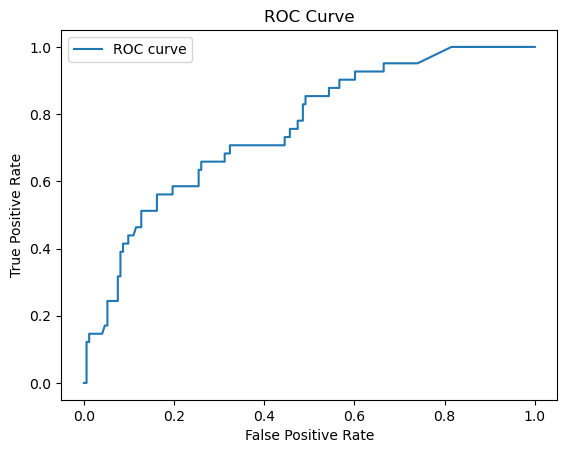

In [34]:
# Using the best model from CV
tuned_model = grid_result.best_estimator_
predictions = tuned_model.predict_proba(X_test)[:, 1]
# Evaluate the model on the testing data
score = tuned_model.score(X_test, y_test)
print('The accuracy of the Random Forest is:', score)

# Calculate the ROC curve for Random Forest
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)

# Plot the ROC curve for Random Forest
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### SVM

In [35]:
# define model and tuning parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.819685 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.788427 (0.031422) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.806443 (0.035383) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.766913 (0.035994) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.796621 (0.022305) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.812677 (0.035255) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.772029 (0.034148) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.806010 (0.019065) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.813032 (0.012677) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.819685 (0.029176) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.804040 (0.012339) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.803283 (0.004366) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.803283 (0.004366) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.803283 (0.004366) with: {'C': 0.01, 'gamma': 'sca

The accuracy of the SVM is: 0.7850467289719626
AUC: 0.597


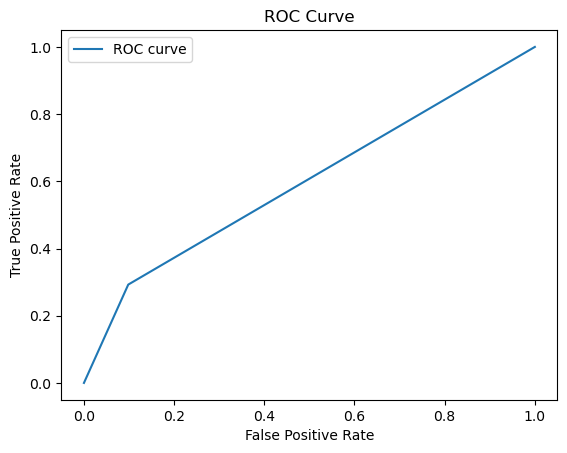

In [37]:
# Using the best model from CV
tuned_model = grid_result.best_estimator_
predictions = tuned_model.predict(X_test)

# Evaluate the model on the testing data
score = tuned_model.score(X_test, y_test)
print('The accuracy of the SVM is:', score)

# Calculate the ROC curve for SVM
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)

# Plot the ROC curve for SVM
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### AdaBoost

In [38]:
# define model and tuning parameters
dtc = DecisionTreeClassifier()
model = AdaBoostClassifier(base_estimator=dtc)
n_estimators = [50, 70, 90, 120, 180, 200]
learning_rate = [0.001, 0.01, 0.1, 1, 10]

# define grid search
grid = dict(n_estimators=n_estimators,learning_rate=learning_rate)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.787684 using {'learning_rate': 10, 'n_estimators': 50}
0.753721 (0.041676) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.752941 (0.043991) with: {'learning_rate': 0.001, 'n_estimators': 70}
0.757209 (0.042965) with: {'learning_rate': 0.001, 'n_estimators': 90}
0.752554 (0.045758) with: {'learning_rate': 0.001, 'n_estimators': 120}
0.756074 (0.042262) with: {'learning_rate': 0.001, 'n_estimators': 180}
0.756069 (0.040739) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.756452 (0.047024) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.756425 (0.041940) with: {'learning_rate': 0.01, 'n_estimators': 70}
0.754838 (0.039495) with: {'learning_rate': 0.01, 'n_estimators': 90}
0.755983 (0.041115) with: {'learning_rate': 0.01, 'n_estimators': 120}
0.755235 (0.042776) with: {'learning_rate': 0.01, 'n_estimators': 180}
0.758368 (0.043596) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.765458 (0.037479) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.759225 (0.0388

The accuracy of the AdaBoost is: 0.7383177570093458
AUC: 0.601


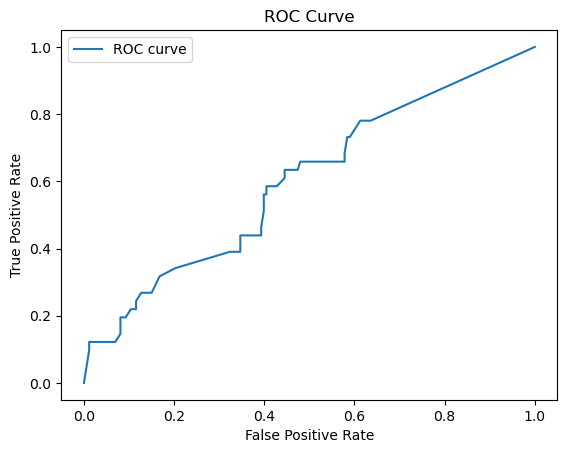

In [39]:
# Using the best model from CV
tuned_model = grid_result.best_estimator_
predictions = tuned_model.predict_proba(X_test)[:, 1]

# Evaluate the model on the testing data
score = tuned_model.score(X_test, y_test)
print('The accuracy of the AdaBoost is:', score)

# Calculate the ROC curve for AdaBoost
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)

# Plot the ROC curve for AdaBoost
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Linear Discriminant Analysis

In [41]:
# define model and tuning parameters
model = LinearDiscriminantAnalysis()
solver = ['svd', 'lsqr', 'eigen']

# define grid search
grid = dict(solver=solver)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train.toarray(), y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.782987 using {'solver': 'svd'}
0.782987 (0.030816) with: {'solver': 'svd'}
0.782987 (0.030816) with: {'solver': 'lsqr'}
0.782987 (0.030816) with: {'solver': 'eigen'}


The accuracy of the Linear Discriminant Analysis is: 0.7476635514018691
AUC: 0.687


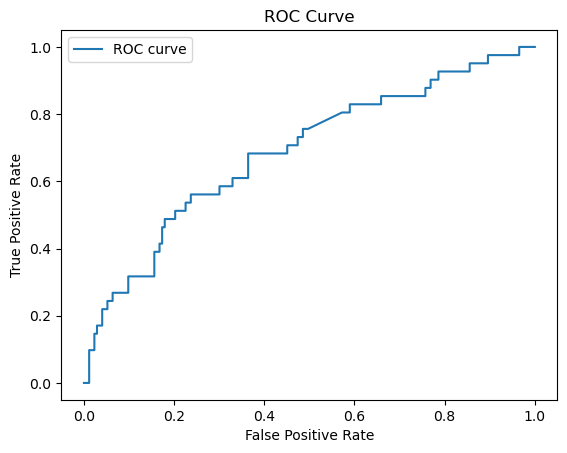

In [42]:
# Using the best model from CV
tuned_model = grid_result.best_estimator_
predictions = tuned_model.predict_proba(X_test.toarray())[:, 1]

# Evaluate the model on the testing data
score = tuned_model.score(X_test.toarray(), y_test)
print('The accuracy of the Linear Discriminant Analysis is:', score)

# Calculate the ROC curve for LDA
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)

# Plot the ROC curve for LDA
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()